In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import umap.umap_ as umap
import hdbscan
import seaborn as sns


In [17]:
#  CONFIG 
BEST_K = 14
UMAP_COMPONENTS = 10
MIN_CLUSTER_SIZE = 200
RANDOM_STATE = 42


In [18]:
#  LOAD DATA 
df = pd.read_csv("../../data/normalized_matches.csv")
print(f"Loaded {len(df)} rows, {len(df.columns)} columns")

Loaded 194400 rows, 204 columns


In [19]:
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

#  TAG ENCODING 
if "tags" in df.columns:
    print("Encoding champion tags")
    tag_dummies = (
        df["tags"]
        .fillna("")
        .str.get_dummies(sep=",")
        .add_prefix("tag_")
    )
    df = pd.concat([df, tag_dummies], axis=1)
    print(f" Added {len(tag_dummies.columns)} tag columns")

Encoding champion tags
 Added 7 tag columns


In [20]:
#  FILTER 
before = len(df)
df = df[
    ~((df["perk_offense"] == 0) &
      (df["perk_flex"] == 0) &
      (df["perk_defense"] == 0))
]
print(f"Filtered {before - len(df)} rows (zero runes)")

Filtered 22785 rows (zero runes)


In [21]:

#  DERIVED FEATURES 
print("Generating derived features")
df["kp_rate"] = df["ch_killParticipation"] / 100
df["damage_share"] = df["ch_teamDamagePercentage"] / 100
df["gold_efficiency"] = df["ch_goldPerMinute"] / df["duration"].clip(lower=1)
df["survivability_ratio"] = df["kills"] / df["deaths"].clip(lower=1)
df["objective_focus"] = (
    df["ch_turretTakedowns"] +
    df["ch_baronTakedowns"] +
    df["ch_dragonTakedowns"]
) / 3
df["vision_efficiency"] = df["ch_visionScorePerMinute"] / (df["ch_wardTakedowns"] + 1)

Generating derived features


In [22]:
#  FEATURES 
features = [
    "kills", "deaths", "assists", "gold_earned", "damage", "vision_score",
    "cs", "win", "duration",
    "kp_rate", "damage_share", "gold_efficiency",
    "objective_focus", "survivability_ratio", "vision_efficiency",
    "primarystyle_id", "primarystyle_perk1", "primarystyle_perk2", "primarystyle_perk3",
    "substyle_id", "substyle_perk1", "substyle_perk2",
    "ch_kda", "ch_killingSprees", "ch_damagePerMinute",
    "ch_teamDamagePercentage", "ch_killParticipation",
    "ch_turretTakedowns", "ch_baronTakedowns", "ch_dragonTakedowns",
    "ch_enemyJungleMonsterKills",
    "ch_goldPerMinute", "ch_laningPhaseGoldExpAdvantage", "ch_maxCsAdvantageOnLaneOpponent",
    "ch_deathsByEnemyChamps", "ch_damageTakenOnTeamPercentage",
    "ch_effectiveHealAndShielding", "ch_saveAllyFromDeath", "ch_immobilizeAndKillWithAlly",
    "attack", "defense", "magic", "difficulty"
]

tag_cols = [c for c in df.columns if c.startswith("tag_")]
features.extend(tag_cols)

available_features = [f for f in features if f in df.columns]
X = df[available_features]
print(f"Using {len(available_features)} features")

Using 50 features


In [23]:
#  SCALE 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=available_features)

weights = {
    "kp_rate": 2.0,
    "damage_share": 2.0,
    "gold_efficiency": 1.5,
    "survivability_ratio": 1.5,
    "vision_efficiency": 1.3,
    "ch_kda": 1.4,
    "ch_damagePerMinute": 1.6,
    "ch_teamDamagePercentage": 1.4,
    "attack": 1.2, "defense": 1.2, "magic": 1.2,
}

for feat, w in weights.items():
    if feat in X_scaled.columns:
        X_scaled[feat] *= w

print("Applied feature weighting to key gameplay stats.")

Applied feature weighting to key gameplay stats.


In [24]:
#  CORRELATION PRUNING 
corr_matrix = X_scaled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]
print(f"Dropping {len(to_drop)} highly correlated features")
X_reduced = X_scaled.drop(columns=to_drop)

Dropping 4 highly correlated features


In [25]:
# OUTLIER TRIMMING (remove 1% tails to tighten clusters)
mask = (np.abs(X_reduced - X_reduced.mean()) < (4 * X_reduced.std())).all(axis=1)
X_trimmed = X_reduced[mask]
print(f"Trimmed {len(X_reduced) - len(X_trimmed)} outliers")

Trimmed 22027 outliers


In [26]:
# UMAP TUNING LOOP 
best_score, best_conf = -1, None
umap_configs = [
    (15, 0.05), (25, 0.1), (30, 0.1), (40, 0.05)
]

for n_neighbors, min_dist in umap_configs:
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=10,
        random_state=RANDOM_STATE,
        metric="cosine"
    )
    X_umap = reducer.fit_transform(X_trimmed)
    kmeans = KMeans(n_clusters=BEST_K, random_state=RANDOM_STATE, n_init=20)
    labels = kmeans.fit_predict(X_umap)
    sil = silhouette_score(X_umap, labels)
    print(f"UMAP(n_neighbors={n_neighbors}, min_dist={min_dist}) → Silhouette={sil:.4f}")
    if sil > best_score:
        best_score = sil
        best_conf = (n_neighbors, min_dist, X_umap, labels)

d:\Github\league-match-grabber\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_neighbors=15, min_dist=0.05) → Silhouette=0.6206


d:\Github\league-match-grabber\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_neighbors=25, min_dist=0.1) → Silhouette=0.5959


d:\Github\league-match-grabber\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_neighbors=30, min_dist=0.1) → Silhouette=0.5928


d:\Github\league-match-grabber\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_neighbors=40, min_dist=0.05) → Silhouette=0.6164


In [27]:
n_neighbors, min_dist, X_umap, labels_kmeans = best_conf
print(f"\n Best UMAP config: n_neighbors={n_neighbors}, min_dist={min_dist}, Silhouette={best_score:.3f}")


 Best UMAP config: n_neighbors=15, min_dist=0.05, Silhouette=0.621


In [40]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, metric="euclidean")
labels_hdb = clusterer.fit_predict(X_umap)
mask = labels_hdb >= 0
sil_hdb = silhouette_score(X_umap[mask], labels_hdb[mask]) if np.sum(mask) > 10 else -1
print(f"HDBSCAN Silhouette: {sil_hdb:.4f}")

d:\Github\league-match-grabber\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Github\league-match-grabber\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN Silhouette: 0.4439


In [41]:
#  METRICS 
ch = calinski_harabasz_score(X_umap, labels_kmeans)
db = davies_bouldin_score(X_umap, labels_kmeans)
print(f"Calinski-Harabasz: {ch:.2f} | Davies-Bouldin: {db:.2f}")

Calinski-Harabasz: 230074.92 | Davies-Bouldin: 0.52



Visualizing KMeans clusters with UMAP embedding...

 Visualizing Clusters 


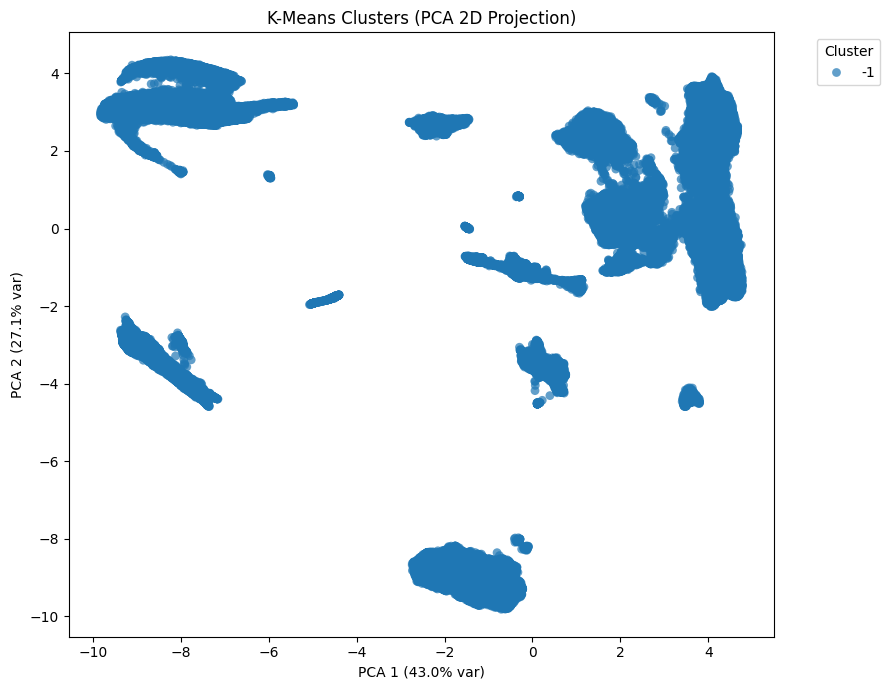

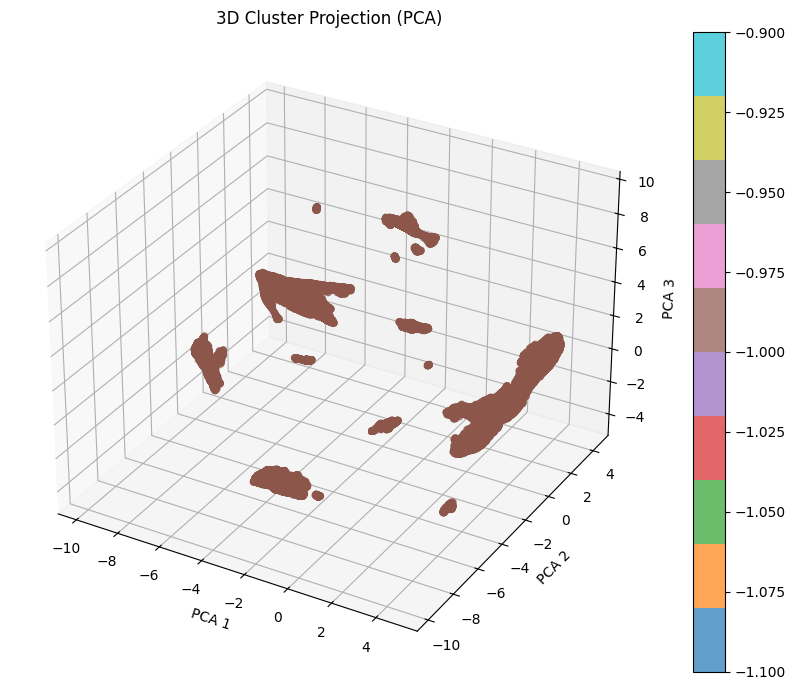

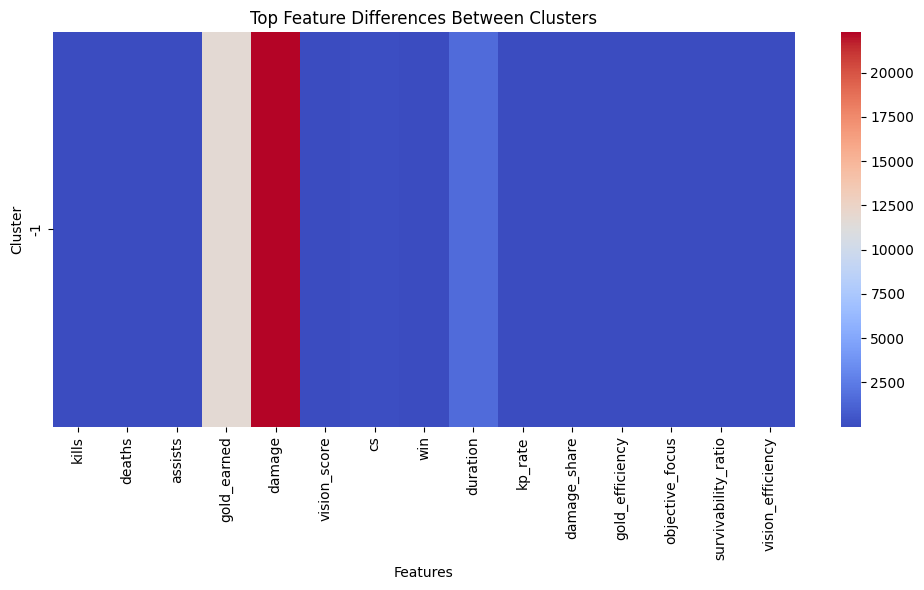

 Visualization complete.


In [ ]:
valid_len = min(len(X_umap), len(df))
df = df.iloc[:valid_len].reset_index(drop=True)
X_umap = X_umap[:valid_len]
labels_kmeans = labels_kmeans[:valid_len]
# === VISUALIZATION ===
from pca import visualize_kmeans  # make sure pca.py is in the same folder

print("\nVisualizing KMeans clusters with UMAP embedding...")

# Ensure we align lengths (since UMAP/KMeans used a trimmed version of df)
df_vis = df.iloc[:len(labels_kmeans)].copy()
df_vis["cluster"] = labels_kmeans

try:
    visualize_kmeans(X_umap[:len(labels_kmeans)], df_vis, kmeans, available_features)
    print(" Visualization complete.")
except Exception as e:
    print(" Visualization failed:", e)

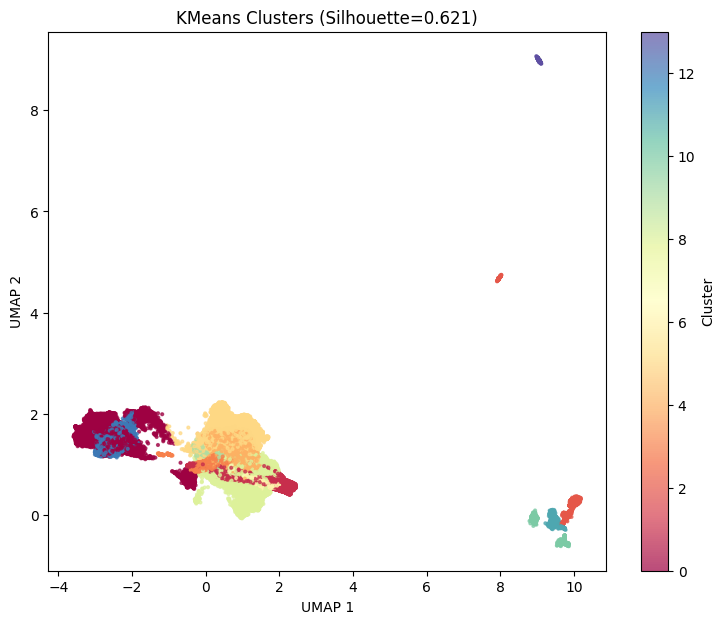

In [30]:
#  VISUALIZE 
plt.figure(figsize=(9,7))
plt.scatter(X_umap[:,0], X_umap[:,1], c=labels_kmeans, s=4, cmap="Spectral", alpha=0.7)
plt.title(f"KMeans Clusters (Silhouette={best_score:.3f})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show() 

In [31]:
#  CLUSTER SUMMARY 
df = df.reset_index(drop=True)
if not isinstance(X_umap, pd.DataFrame):
    X_umap = pd.DataFrame(X_umap)

print(f"Aligning indices: df={len(df)}, X_umap={len(X_umap)}")

# Create cluster columns safely
df["cluster_kmeans"] = -1
df["cluster_hdbscan"] = -1

# --- Assign KMeans clusters (same length as X_umap)
if len(labels_kmeans) == len(df):
    df["cluster_kmeans"] = labels_kmeans
else:
    df.iloc[:len(labels_kmeans), df.columns.get_loc("cluster_kmeans")] = labels_kmeans

# --- Assign HDBSCAN clusters (may trim outliers)
if len(labels_hdb) == len(df):
    df["cluster_hdbscan"] = labels_hdb
else:
    df.iloc[:len(labels_hdb), df.columns.get_loc("cluster_hdbscan")] = labels_hdb

# === SUMMARY STATS ===
print("\nCluster Summary (KMeans):")
summary_kmeans = df.groupby("cluster_kmeans")[available_features].mean().round(2)
display(summary_kmeans.head(10))

print("\nCluster Summary (HDBSCAN):")
summary_hdb = df.groupby("cluster_hdbscan")[available_features].mean().round(2)
display(summary_hdb.head(10))

# === SAVE OUTPUT ===
df.to_csv("../../data/clustered_umap_hdb_kmeans.csv", index=False)
print("Saved clustered dataset with both KMeans + HDBSCAN outputs.")


Aligning indices: df=171615, X_umap=149588

Cluster Summary (KMeans):


,kills,deaths,assists,gold_earned,damage,vision_score,cs,win,duration,kp_rate,...,defense,magic,difficulty,tag_0,tag_Assassin,tag_Fighter,tag_Mage,tag_Marksman,tag_Support,tag_Tank
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
-1,6.65,6.72,10.94,11657.78,22302.94,20.47,128.76,0.5,1573.37,0.0,...,4.30,5.13,5.56,0.00,0.29,0.31,0.44,0.25,0.26,0.23
0,6.63,6.67,10.79,11653.24,22239.41,20.84,130.36,0.5,1581.92,0.0,...,4.30,5.08,5.55,0.00,0.29,0.32,0.44,0.24,0.26,0.22
1,6.67,6.69,10.74,11674.42,22222.08,20.86,130.31,0.5,1576.67,0.0,...,4.29,5.05,5.54,0.00,0.29,0.31,0.43,0.25,0.26,0.23
2,6.69,6.60,10.61,11690.55,22457.94,20.45,132.57,0.5,1574.10,0.0,...,4.31,5.06,5.51,0.01,0.28,0.32,0.44,0.26,0.25,0.23
3,6.69,6.69,10.70,11660.74,22338.22,20.79,130.77,0.5,1577.06,0.0,...,4.31,5.11,5.53,0.00,0.29,0.31,0.44,0.24,0.26,0.22
4,6.64,6.67,10.82,11651.94,22152.55,20.49,130.18,0.5,1573.09,0.0,...,4.33,5.07,5.52,0.00,0.29,0.32,0.44,0.25,0.25,0.23
5,6.63,6.70,10.78,11694.37,22344.42,20.84,130.97,0.5,1583.47,0.0,...,4.31,5.09,5.53,0.00,0.29,0.32,0.44,0.24,0.26,0.23
6,6.72,6.66,10.84,11748.09,22469.80,20.35,132.39,0.5,1586.91,0.0,...,4.30,5.08,5.54,0.00,0.29,0.32,0.45,0.24,0.25,0.22
7,6.60,6.65,10.48,11582.20,21879.23,20.42,129.93,0.5,1566.74,0.0,...,4.31,5.00,5.54,0.00,0.30,0.32,0.42,0.25,0.25,0.23



Cluster Summary (HDBSCAN):


,kills,deaths,assists,gold_earned,damage,vision_score,cs,win,duration,kp_rate,...,defense,magic,difficulty,tag_0,tag_Assassin,tag_Fighter,tag_Mage,tag_Marksman,tag_Support,tag_Tank
cluster_hdbscan,,,,,,,,,,,,,,,,,,,,,
-1,6.65,6.71,10.91,11651.61,22284.98,20.43,128.86,0.50,1572.79,0.0,...,4.30,5.13,5.56,0.00,0.29,0.31,0.44,0.24,0.26,0.23
0,6.77,6.51,10.18,11680.73,22008.40,22.75,134.66,0.53,1600.66,0.0,...,4.12,5.13,5.47,0.01,0.26,0.26,0.45,0.27,0.30,0.21
1,6.89,6.81,11.72,12044.97,22450.92,21.42,132.70,0.52,1600.92,0.0,...,4.25,4.97,5.63,0.00,0.29,0.28,0.43,0.29,0.28,0.22
2,6.70,6.29,9.80,11544.53,21748.52,22.20,127.94,0.51,1568.70,0.0,...,4.13,5.22,5.56,0.00,0.28,0.30,0.50,0.25,0.25,0.18
3,6.88,6.80,10.88,11957.10,22903.07,21.31,134.12,0.50,1605.94,0.0,...,4.32,4.85,5.61,0.00,0.31,0.34,0.39,0.26,0.24,0.23
4,6.68,6.69,10.77,11633.94,22208.66,20.69,129.75,0.48,1569.31,0.0,...,4.22,5.13,5.59,0.01,0.29,0.31,0.45,0.25,0.26,0.21
5,6.54,6.65,10.58,11562.98,21712.21,20.07,128.72,0.49,1557.76,0.0,...,4.34,5.02,5.58,0.00,0.29,0.32,0.43,0.24,0.25,0.23
6,6.73,6.71,10.80,11759.76,22249.22,20.47,130.79,0.50,1582.56,0.0,...,4.34,5.10,5.57,0.00,0.29,0.30,0.43,0.25,0.26,0.24
7,6.27,6.61,10.74,11459.96,21147.88,21.47,125.75,0.48,1547.10,0.0,...,4.32,5.05,5.45,0.00,0.29,0.31,0.42,0.23,0.28,0.24


Saved clustered dataset with both KMeans + HDBSCAN outputs.
